In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from sklearn.model_selection import train_test_split
from statsmodels.formula.api import ols
from sklearn import linear_model

df=pd.read_excel("Complete-dataset-FINAL.xlsx")

### Note
Dit model is een alternatief voor de lineare regressie model. De algemene bunsiness & data understanding zijn te vinden in de Jupyter notebook van de lineare regressie. In deze notebook zal er gefocust worden op het voorspellingsmodel (ARIMA model).

# Business understanding
We gaan het ARIMA model gebruiken. Hier gaan we kijken of de data stationair is, wat betekent dat een tijdsreeks niet afhankelijk is van tijd. Eerst zullen de parameters voor het ARIMA model worden bepaald. ARIMA(p=?, d=?,q=?)

### ARIMA model
Het doel van een ARIMA model is het nabootsen van een tijdsserie. Dit wordt gedaan door de variaties in de data te modelleren door middel van de volgende drie opties: 

- AR (auto-regressief), voorgaande waardes worden gebruikt om nieuwe waardes te voorspellen.
- I (integrated), niet de originele serie maar een gedifferentieerde tijdsserie wordt gebruikt. Dit om de tijdsserie stationair te maken. 
- MA (moving average), voorafgaande fouten worden gebruikt om nieuwe fouten voorspellen. Dit heeft een smoothing effect, een bewegend gemiddelde. 

Door deze effecten te mengen kun je de meeste tijdsseries nabootsen. In de volgende sectie gaan we de effecten van de AR en MA termen op een tijdsserie bekijken. 



# Data preparation

In [3]:
df=df.dropna()
df.columns = df.columns.str.replace('Total Error', 'Total')
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Year,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total
0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,2011.0,CAP,Fresh,Vitros,4.348
1,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,2011.0,CAP,Fresh,Vitros,4.890
2,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,2011.0,CAP,Fresh,Vitros,6.100
3,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,2012.0,CAP,Fresh,Vitros,4.328
4,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,2012.0,CAP,Fresh,Vitros,5.036


In [4]:
df=df.set_index('Year')
df.head()

,Method name,N (no. labs),Mean,Bias,CV,Sample,Reference Value,Source (CAP/EurA1c),Type (Fresh/frozen),Manufacturer,Total
Year,,,,,,,,,,,
2011.0,Vitros 5.1 FS. 4600. 5600,183,6.14,-0.16,2.3,GH2-04,6.3,CAP,Fresh,Vitros,4.348
2011.0,Vitros 5.1 FS. 4600. 5600,183,7.59,-0.01,2.5,GH2-05,7.6,CAP,Fresh,Vitros,4.890
2011.0,Vitros 5.1 FS. 4600. 5600,183,9.42,0.22,3.0,GH2-06,9.2,CAP,Fresh,Vitros,6.100
2012.0,Vitros 5.1 FS. 4600. 5600,210,5.42,-0.18,2.3,GH2-01,5.6,CAP,Fresh,Vitros,4.328
2012.0,Vitros 5.1 FS. 4600. 5600,210,9.34,-0.06,2.6,GH2-02,9.4,CAP,Fresh,Vitros,5.036


In [5]:
list_top10 = df['Manufacturer'].value_counts()[:10].index.tolist()
top10_manufacturers = df.loc[df['Manufacturer'].isin(list_top10)]
top10_manufacturers['Manufacturer'].value_counts()


Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
Name: Manufacturer, dtype: int64

In [6]:
# manufacturers = df.groupby("Manufacturer")
manufacturers = top10_manufacturers.groupby("Manufacturer")
manufacturers.size().nlargest(20)

Manufacturer
Siemens              918
Bio-Rad              667
Roche Diagnostics    605
Beckman Coulter      349
Tosoh                284
Abbott               278
Sebia                201
Trinity Biotech      185
Vitros               139
Alere                111
dtype: int64

In [7]:
top10_manufacturers = top10_manufacturers.dropna()
# top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total', 'Year']]
top10_manufacturers=top10_manufacturers[['Manufacturer', 'Total']]
top10_manufacturers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 3737 entries, 2011.0 to 2021.0
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Manufacturer  3737 non-null   object 
 1   Total         3737 non-null   float64
dtypes: float64(1), object(1)
memory usage: 87.6+ KB


In [8]:
# sns.lineplot(x="Year", y="Total",
#              hue="Manufacturer", 
#              data=top10_manufacturers)

Abbott


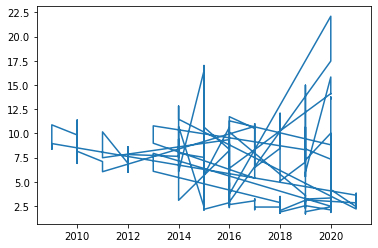

Alere


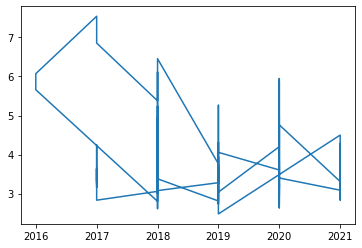

Beckman Coulter


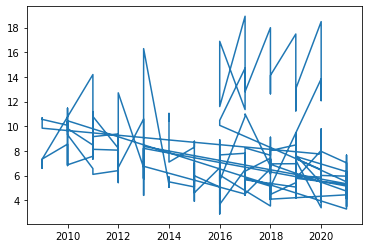

Bio-Rad


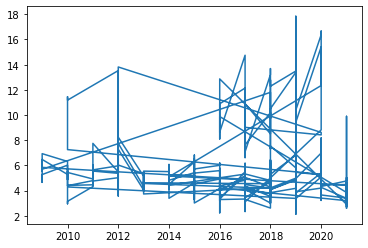

Roche Diagnostics


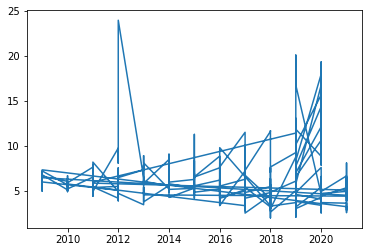

Sebia


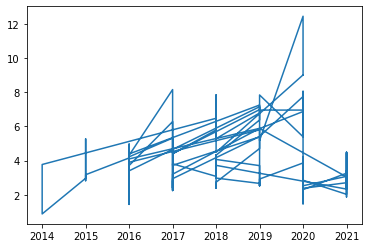

Siemens


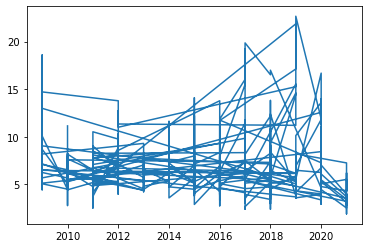

Tosoh


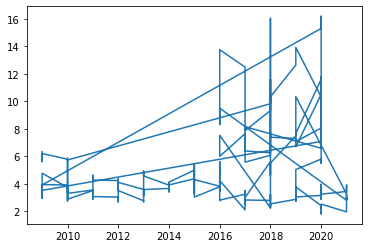

Trinity Biotech


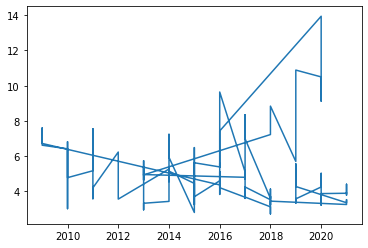

Vitros


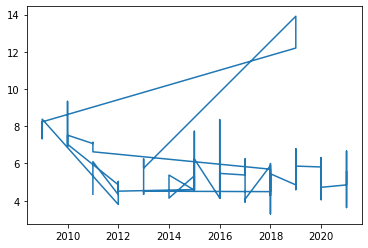

In [9]:
for name, data in manufacturers:
    print(name)
    plt.plot(data['Total'])
    plt.show()

# Modeling

#model regressie trainen en testen
#R2 zegt iets over de bruikbaarheid van je model
traindata, testdata = train_test_split(Siemens, train_size=0.65, test_size=0.35, random_state=42)

#eerst afhankelijke variabele, dus hierbij 'Manufacturer'
mod1 = ols(formula='Year ~ Total', data=traindata).fit()
print(mod1.summary())

In [10]:
# traindata, testdata = train_test_split(df, train_size=0.65, test_size=0.35, random_state=42)

# X_train, X_test, Y_train, Y_test = train_test_split(df["Year"].values, df["Manufacturer"].values, test_size = .20, random_state = 40)
top10_manufacturers= top10_manufacturers.dropna()


In [11]:
# Check for stationarity of the time-series data
# We will look for p-value. In case, p-value is less than 0.05, the time series data can said to have stationarity
from statsmodels.tsa.stattools import adfuller
manufacturers = top10_manufacturers.groupby("Manufacturer")
#differentiate with last value -? first value is always nan
#AIC input is to compute the optimal number iteratively.
for name, data in manufacturers: 
    data= data.dropna()
    print(name) 
    df_stationarityTest = adfuller(data['Total'], autolag='AIC')    
    # print("P-value: one ", df_stationarityTest[1])

    # df_stationarityTest = adfuller(data['Total'].diff().diff().dropna(), autolag='AIC')    
    # print("P-value: two ", df_stationarityTest[1])

    # df_stationarityTest = adfuller(data['Total'].diff().diff().diff().dropna(), autolag='AIC')    
    # print("P-value: three ", df_stationarityTest[1])

    # df_stationarityTest = adfuller(data['Total'].diff().diff().diff().diff().dropna(), autolag='AIC')    
    # print("P-value: four", df_stationarityTest[1])
    print("\n")
    print(f'ADF Statistic: {df_stationarityTest[0]}')
    print(f'n_lags: {df_stationarityTest[1]}')
    print(f'p-value: {df_stationarityTest[1]}')
    for key, value in df_stationarityTest[4].items():
        print('Critial Values:')
        print(f'   {key}, {value}')    

    print("\n")

Abbott
P-value: four 0.29105796634827763


ADF Statistic: -1.9898120102862134
n_lags: 0.29105796634827763
p-value: 0.29105796634827763
Critial Values:
   1%, -3.4554613060274972
Critial Values:
   5%, -2.8725931472675046
Critial Values:
   10%, -2.5726600403359887


Alere
P-value: four 0.0003783913537194656


ADF Statistic: -4.340042847938978
n_lags: 0.0003783913537194656
p-value: 0.0003783913537194656
Critial Values:
   1%, -3.49181775886872
Critial Values:
   5%, -2.8884437992971588
Critial Values:
   10%, -2.5811201893779985


Beckman Coulter
P-value: four 0.016450142108014498


ADF Statistic: -3.2663735133490923
n_lags: 0.016450142108014498
p-value: 0.016450142108014498
Critial Values:
   1%, -3.4495033946549123
Critial Values:
   5%, -2.8699787979596136
Critial Values:
   10%, -2.5712658305164955


Bio-Rad
P-value: four 1.4889943958397245e-05


ADF Statistic: -5.086968935872926
n_lags: 1.4889943958397245e-05
p-value: 1.4889943958397245e-05
Critial Values:
   1%, -3.440513273781259

### Analyse van p-values
Een p-value van 0.05 of er onder ligt, betekent dat de data stationair is. De resultaten laten zien dat de data niet stationair is. De voorspelling van de tijdsreeks niet volledig afhankkelijk zijn. Dit betekent dat de resultaten een ongeschikte voorspelling creëren.

Abbott


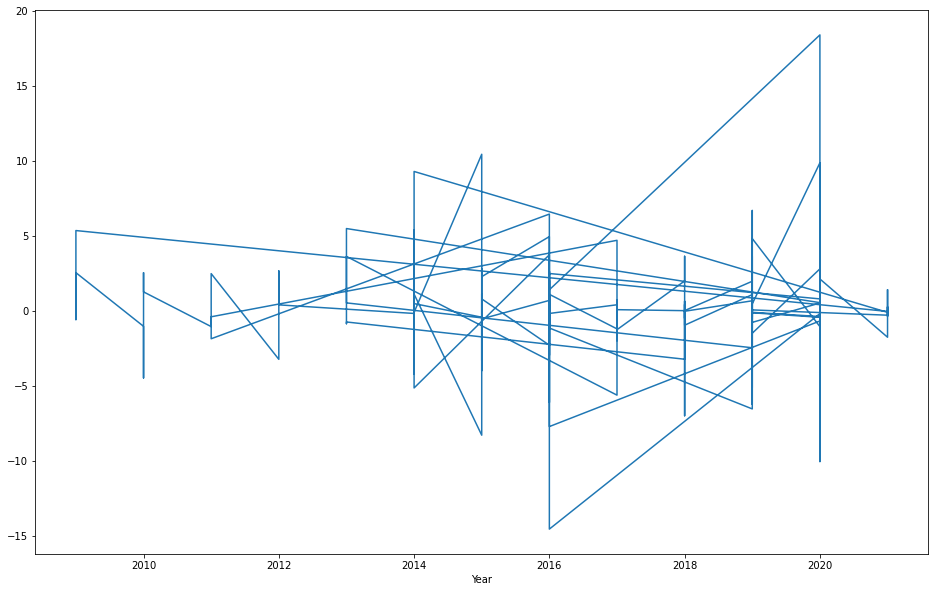

Alere


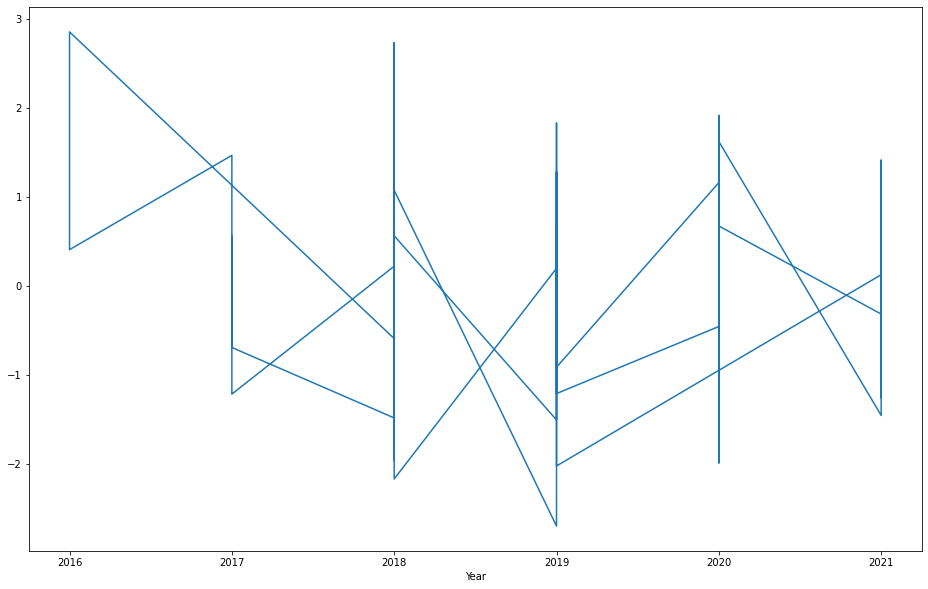

Beckman Coulter


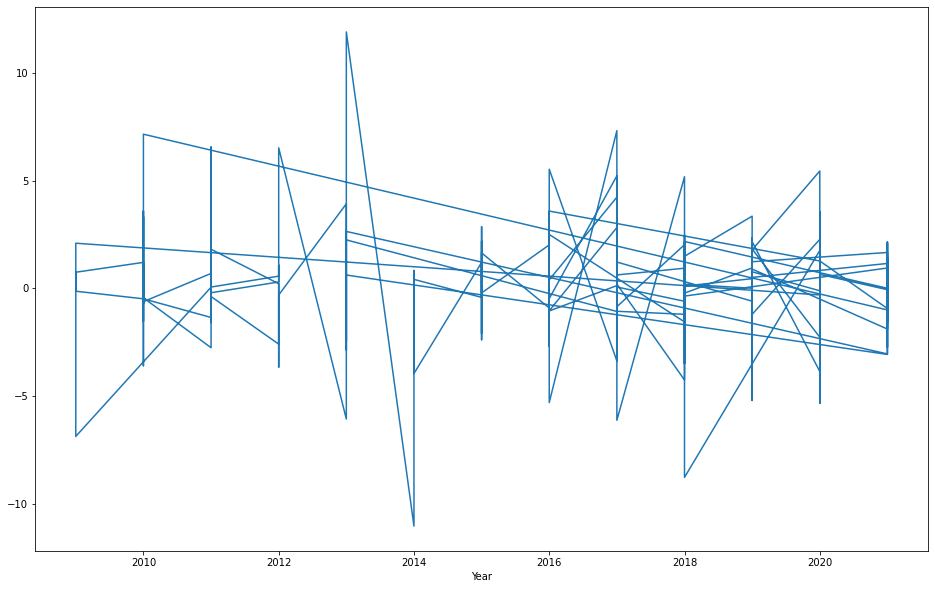

Bio-Rad


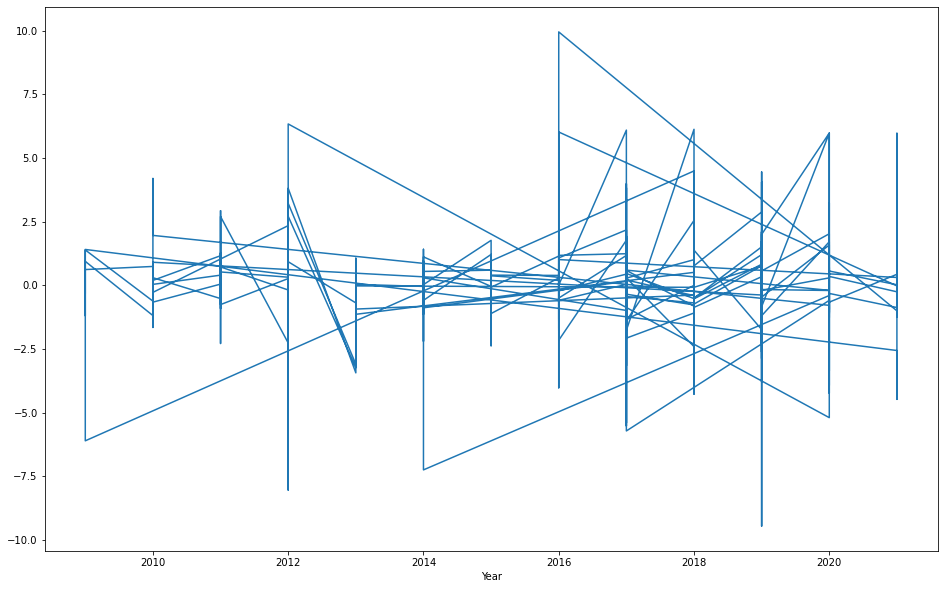

Roche Diagnostics


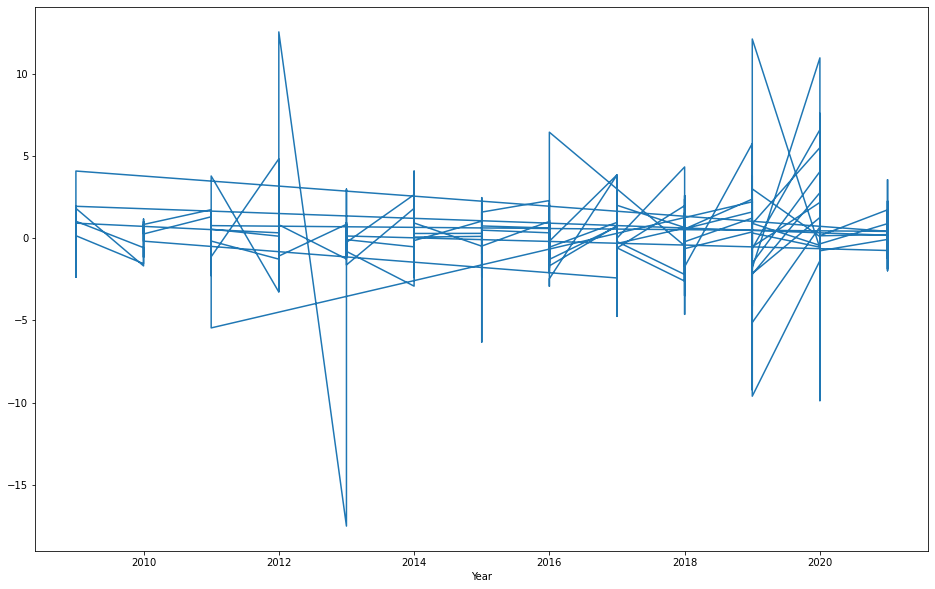

Sebia


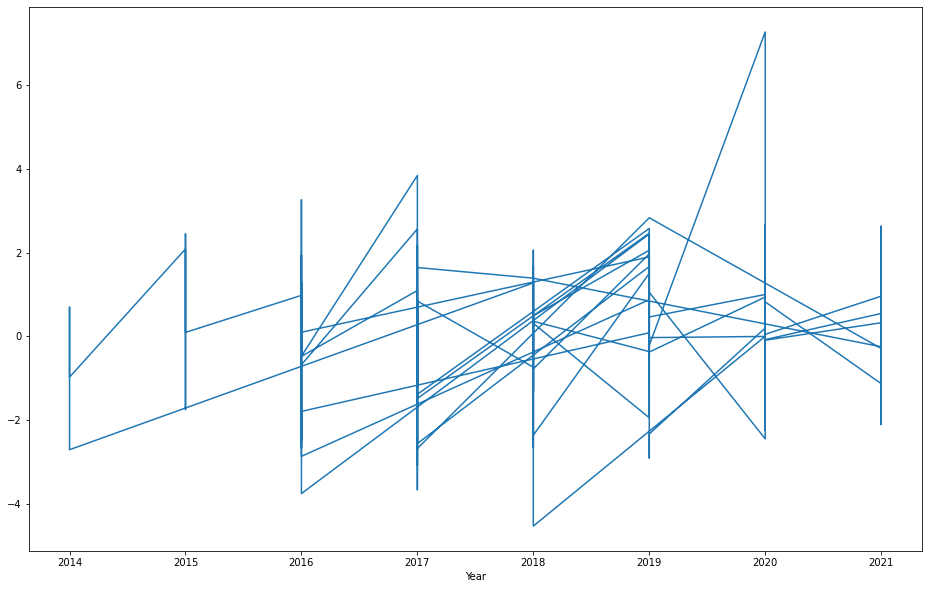

Siemens


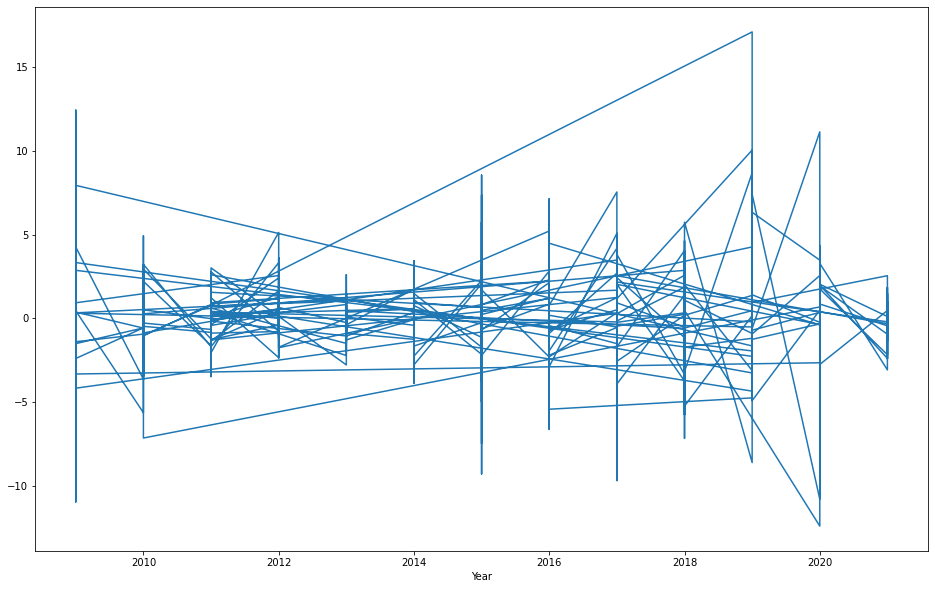

Tosoh


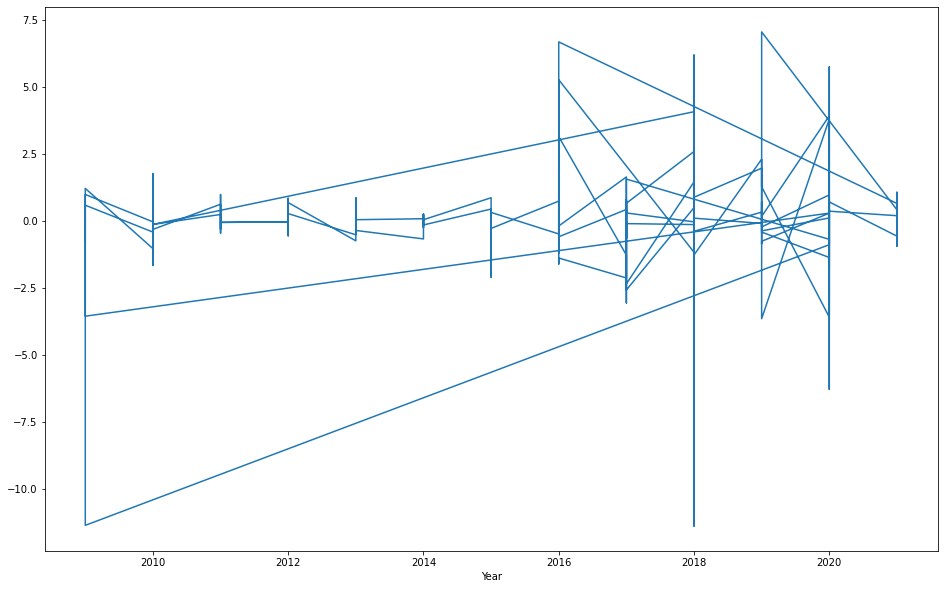

Trinity Biotech


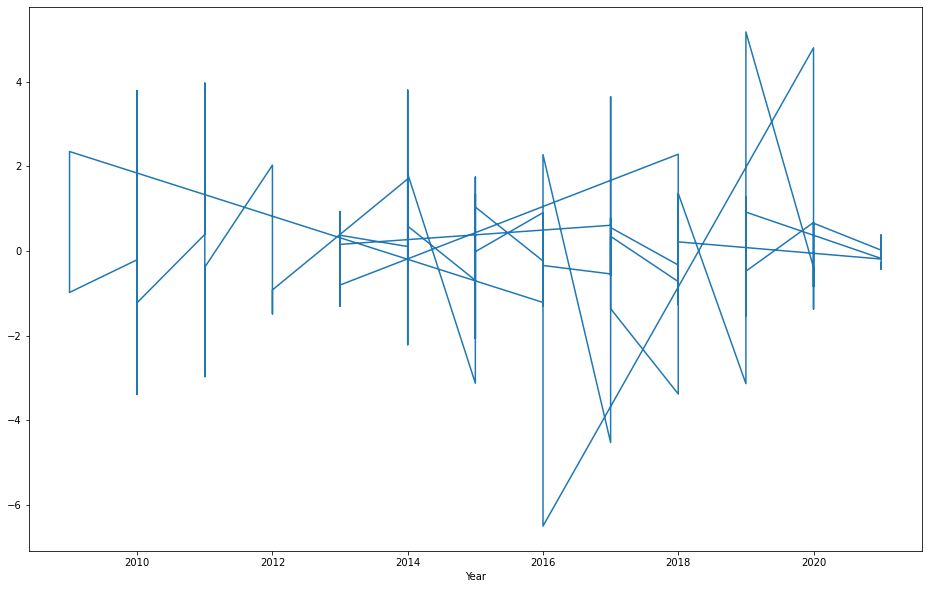

Vitros


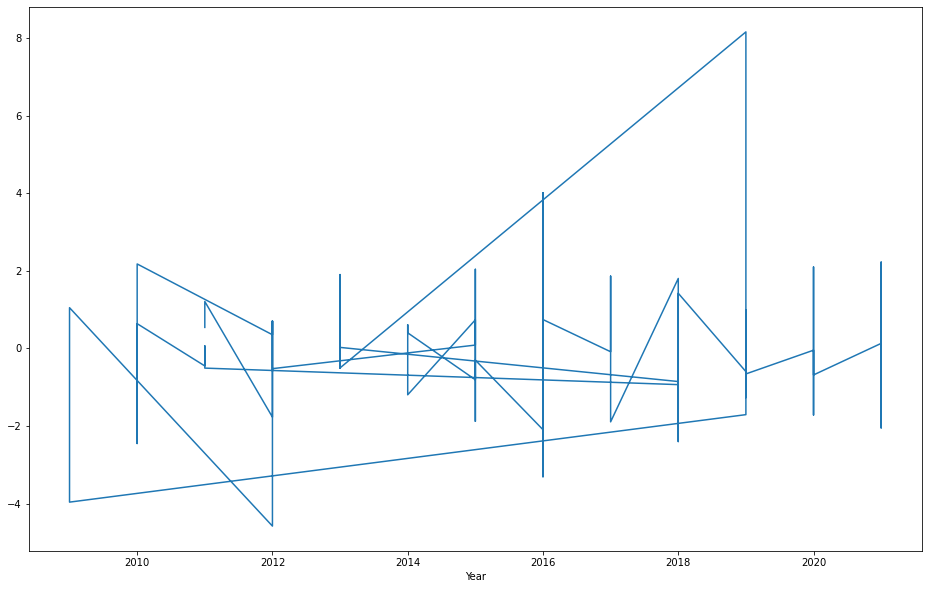

In [12]:
for name, data in manufacturers:
    print(name)
    data['Total'].diff().plot(figsize=(16,10))
    plt.show()

Abbott


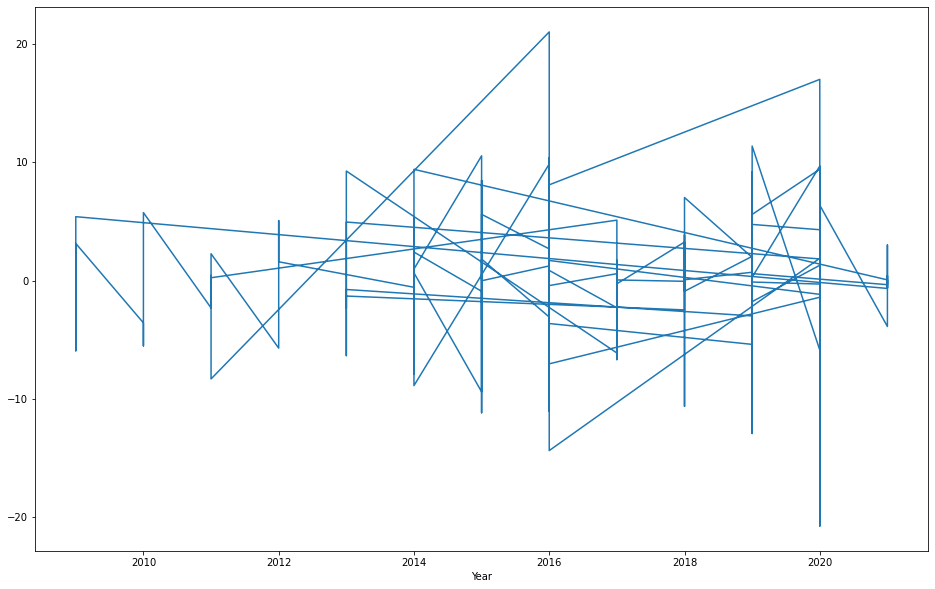

Alere


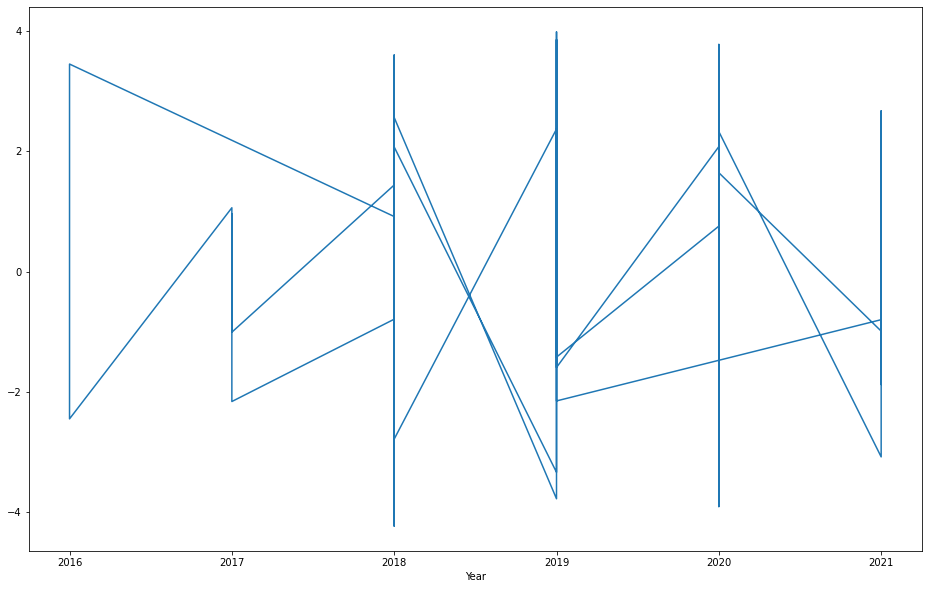

Beckman Coulter


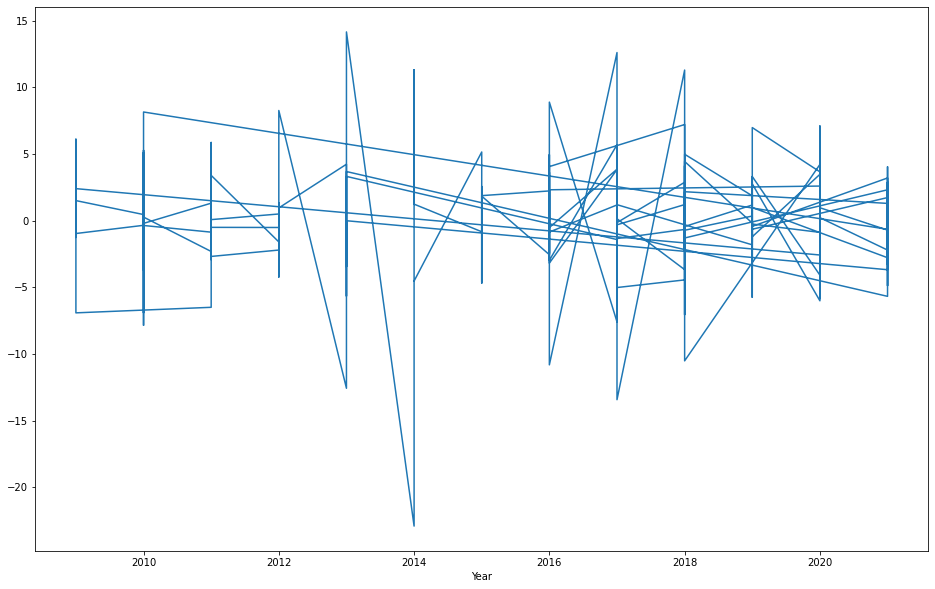

Bio-Rad


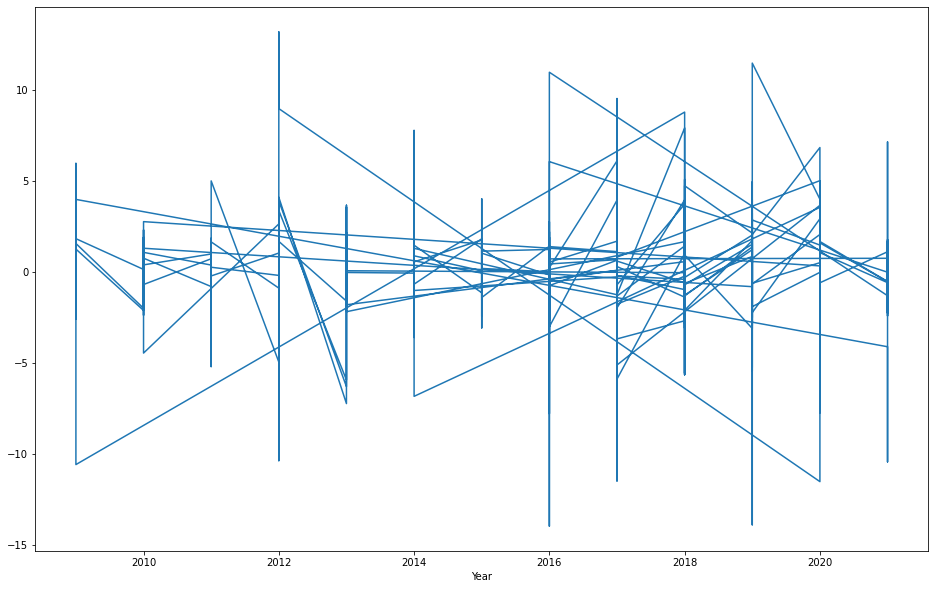

Roche Diagnostics


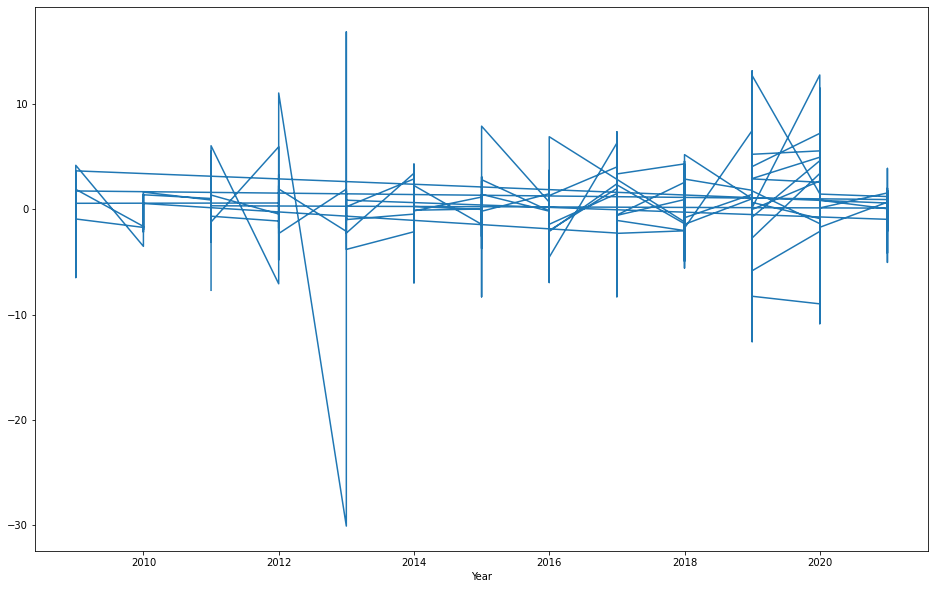

Sebia


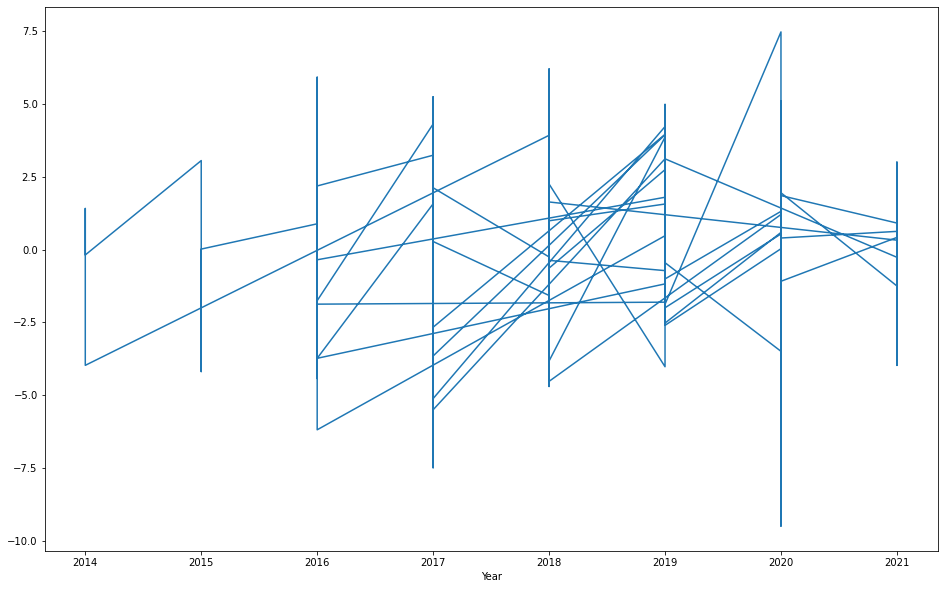

Siemens


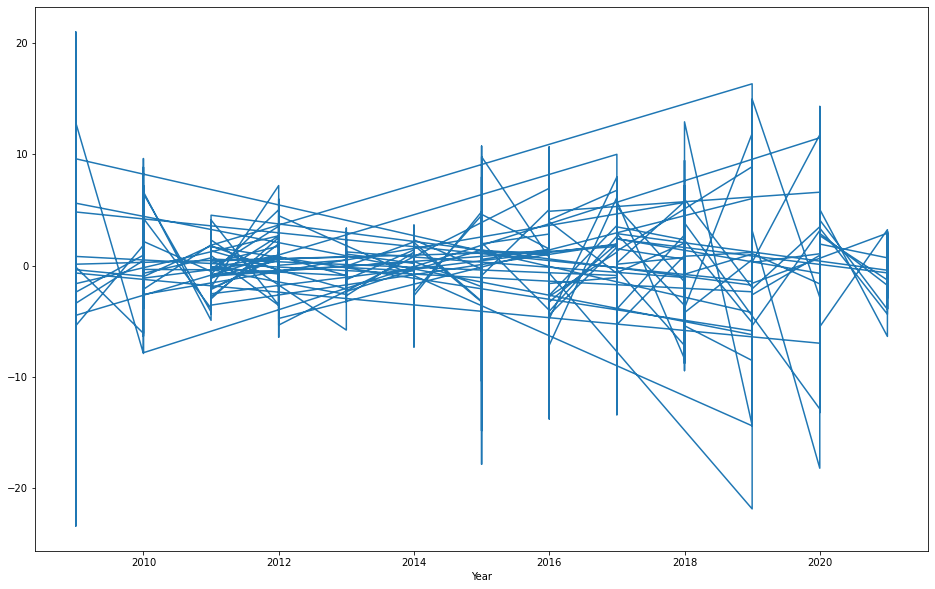

Tosoh


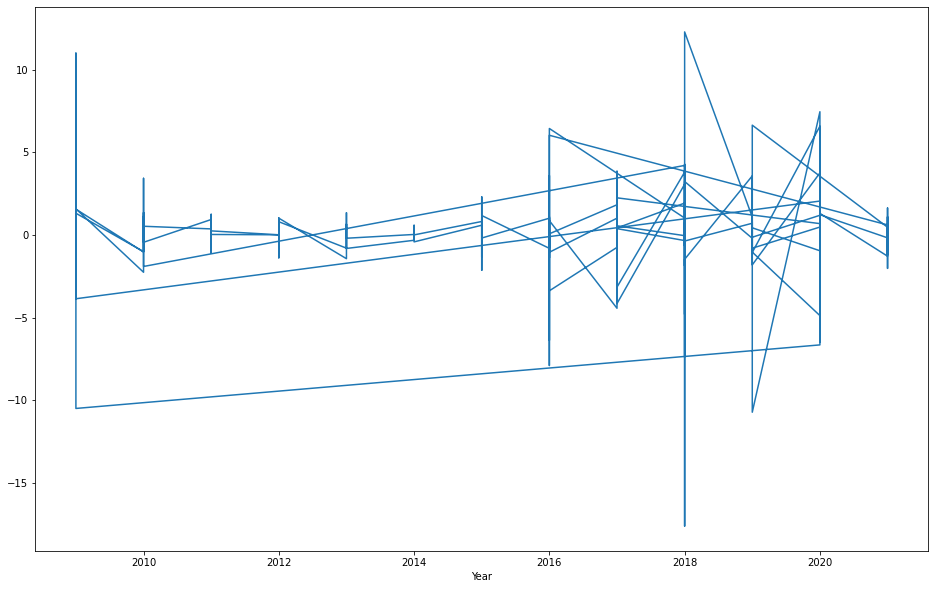

Trinity Biotech


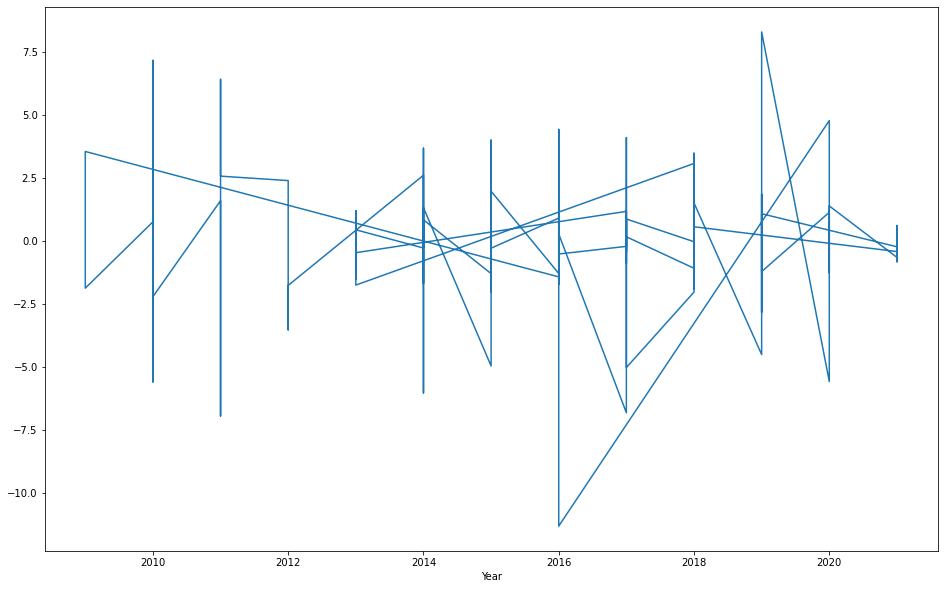

Vitros


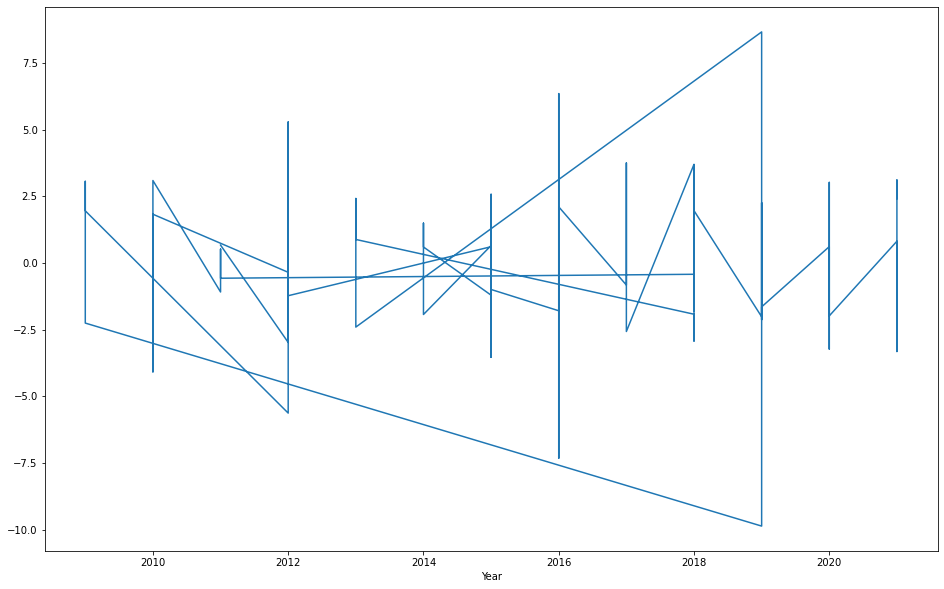

In [13]:

for name, data in manufacturers:
    print(name)
    data['Total'].diff().diff().plot(figsize=(16,10))
    plt.show()


#2x diff = I (ARIMA)


# Analyse autocorrelation plot
Hier is te zien dat bij de 2 keer differentiëren de data meer stationair lijkt. Daarom nemen we 2 als parameter. Dus ARIMA(p=?,d=2,q=?)

# Data preparation ACF & PACF

In [14]:
# data['Total'] = data['Total'].diff().diff().dropna()

### ACF plot

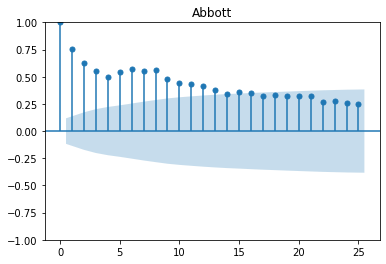

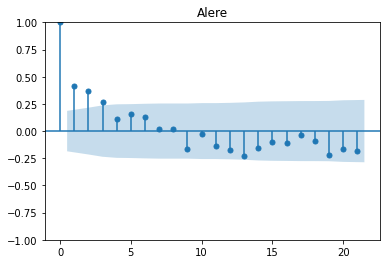

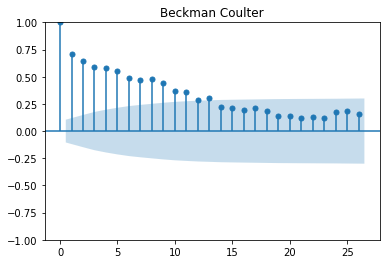

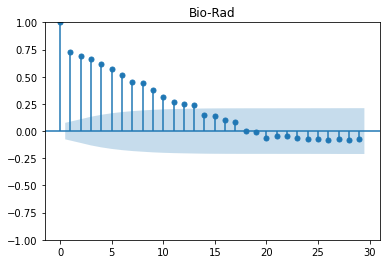

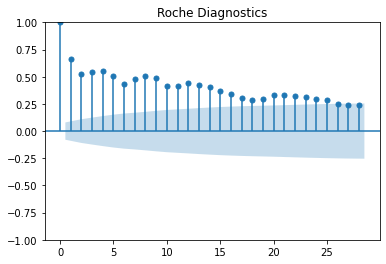

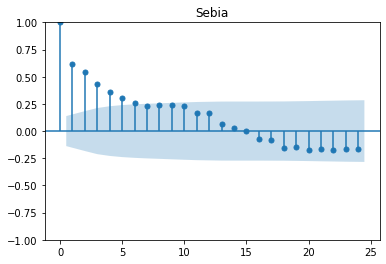

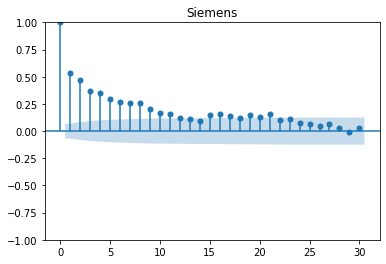

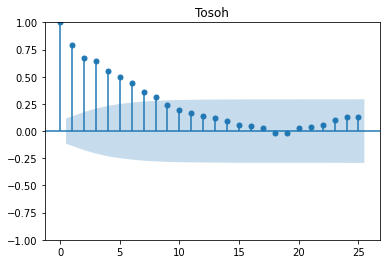

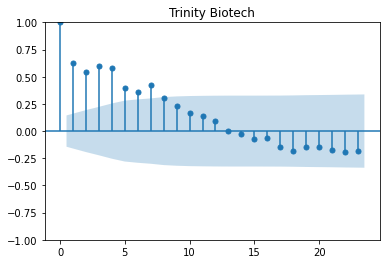

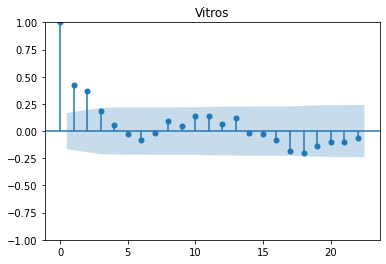

In [15]:
from statsmodels.graphics.tsaplots import plot_acf
for name, data in manufacturers: 
    acf =plot_acf(data['Total'], title=name)

### Analyse van ACF plot
In dit autocorrelatieplot liggen bijna alle waardes niet binnen het lichtblauwe onzekerheidsgebied (deze variantie in autocorrelatie kan worden verklaard door ruis). Dit betekent dat we wel MA-parameter hoeven in te stellen.

Voor de zekerheid bekijken we ook de autocorrelaties met een lag van twee weken.

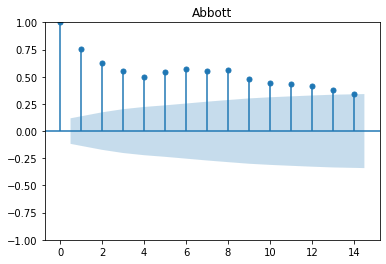

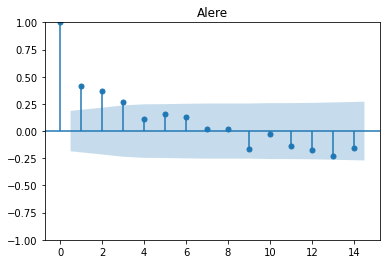

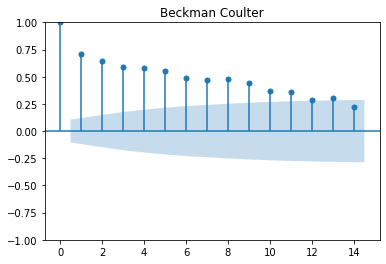

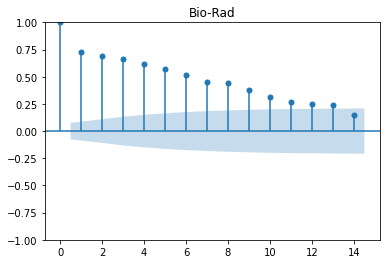

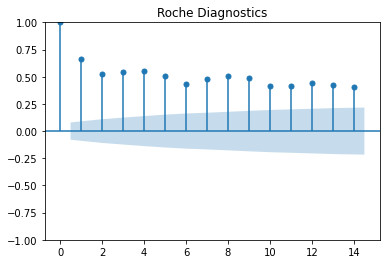

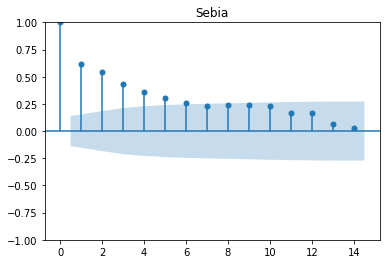

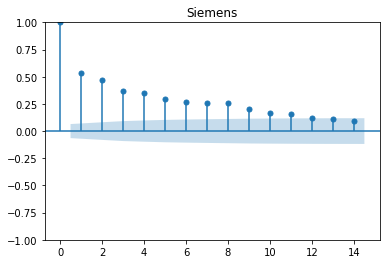

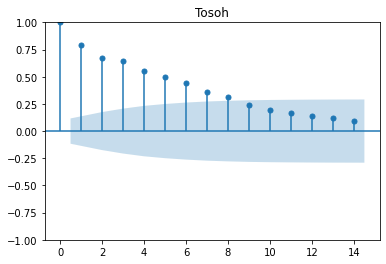

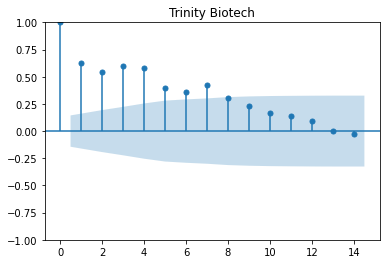

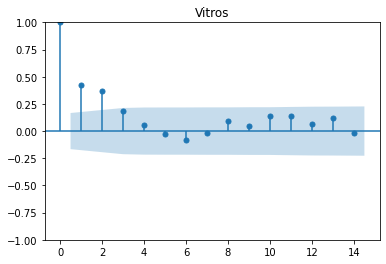

In [16]:
for name, data in manufacturers: 
    plot_acf(data['Total'], lags=14, title=name)

C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(
C:\Users\femke\AppData\Roaming\Python\Python310\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.w

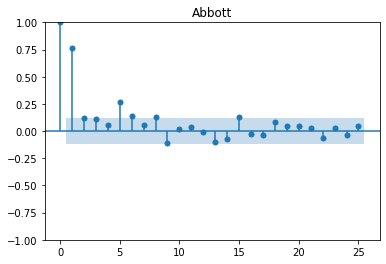

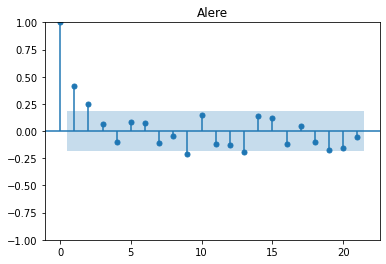

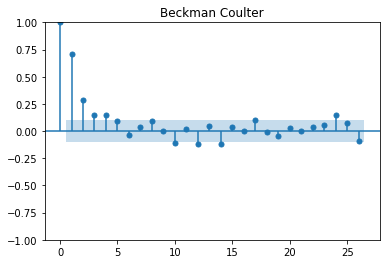

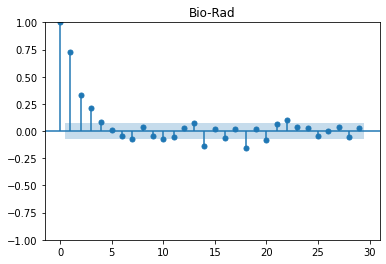

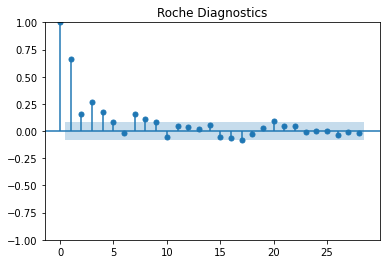

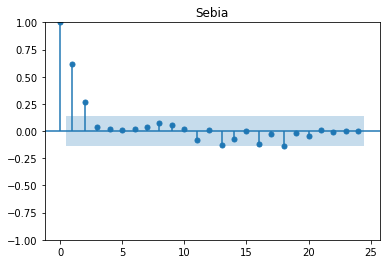

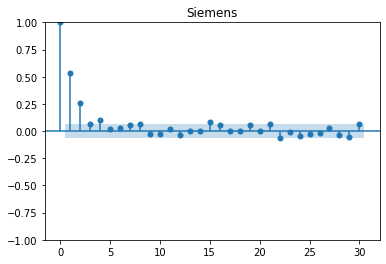

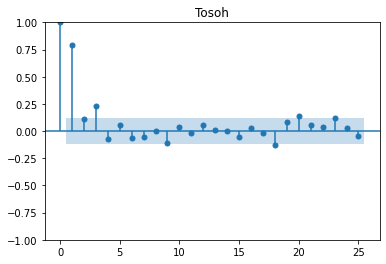

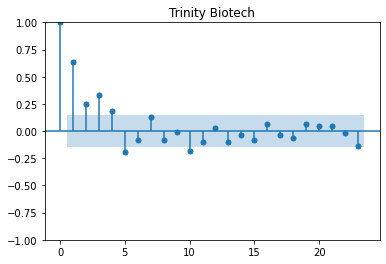

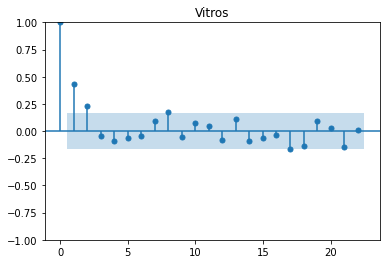

In [17]:
from statsmodels.graphics.tsaplots import plot_pacf

for name, data in manufacturers: 
    pacf = plot_pacf(data['Total'], title=name)

### Analyse van pacf plot
De partiële autocorrelatie geeft weer hoe sterk het verband is tussen de waarde van een lag en de waarde van voorgaande lags. Als er tussen de lags nog significante correlatie bestaat is dit een aanwijzing dat er auto-correlatie optreed en dat het instellen van de AR parameter een goed idee is.

Bij alle grafieken is te zien dat de eerste lag het meest significant is. Daarom nemen we p met de waarde 1. Dus ARIMA(p=1,d=2,q=?)

In [18]:
# from pandas.plotting import autocorrelation_plot
# for name, data in manufacturers: 
#     plt.title(f"Autocorrelation Plot: {name}")
#     autocorrelation_plot(data['Total'])
#     plt.show()

In [19]:
from statsmodels.tsa.ar_model import AutoReg
# Create training and test data
for name, data in manufacturers:
    train_data = data['Total'][:len(df)-100]
    test_data = data['Total'][len(df)-100:]
    #
    # Instantiate and fit the AR model with training data
    #
    ar_model = AutoReg(train_data, lags=1).fit()
    #
    # Print Summary
    #
    print(ar_model.summary())
    

KeyError: 3958

# ARIMA modeling

In [ ]:
# for name, data in manufacturers:
#     tempdf = df[['Year', 'Total']].dropna()

#     X = tempdf.iloc[:, :-1].values
#     Y = tempdf.iloc[:, 1].values

#     from sklearn.model_selection import train_test_split
#     X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.3, random_state=0)

#     from sklearn.linear_model import LinearRegression
#     regressor = LinearRegression()
#     regressor.fit(X_train, Y_train)

#     print(regressor.intercept_)
#     from matplotlib import pyplot

    
# for name, data in manufacturers:
#     # line plot for Total Error with seaborn
#     # if name == "Abbott":
#         # sns.set(rc = {'figure.figsize':(25,8)})
#         # l = sns.lineplot(x='Year', y='Total Error', data=data)
#         # sns.lineplot(x='Year', y={regressor.intercept_}, data=data)
#         # l.set_title(name)
#         # plt.show()
#         pyplot.plot('Year','Total Error',data=tempdf, color='red')
#         pyplot.plot('Year','Total Error', data=regressor.intercept_)

# Arima model

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

for name, data in manufacturers:
    model = ARIMA(data['Total'], order=(0,2,0))
    model_fit = model.fit()
    print(model_fit.summary())
    fig = model_fit.plot_predict('2022',dynamic=False)

#P>|z| significant? onder 0.01

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.
